## Ejercicios con Python Tarea Clase 21
### Pablo Ángel Mendoza Aguirre

Realizar la valuación de las opciones amaericanas Call y Put para las acciones de Yelp, siguiendo los siguientes lineamientos:
1. Realizar la valuación usando la suposición de rendimientos normales. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.

In [1]:
import datetime
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import pandas_datareader.data as web
from datetime import datetime, timedelta
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def get_historical_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    pd.core.common.is_list_like = pd.api.types.is_list_like 
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]
def min_cuad_americanas(x,y):
    A = np.zeros([len(x),3])
    A[:,0] = np.ones(len(x)).T
    A[:,1] = x.T
    A[:,2] = (x**2).T
    coeficientes = np.dot(np.linalg.pinv(A),y)
    return coeficientes

### Precios de los Activos a lo Largo del Tiempo

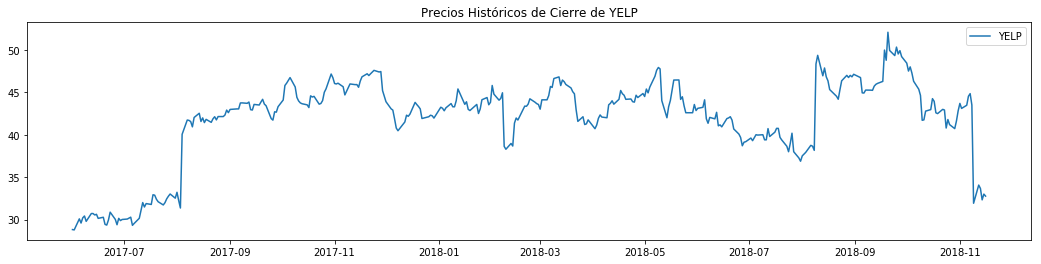

In [3]:
ticker1 = ['YELP']
start_date = '2017-06-01'
end_date = '2018-11-15'
closes_ma = get_historical_closes(ticker1, start_date,end_date,'d')
plt.figure(figsize = (18,4))
plt.title('Precios Históricos de Cierre de YELP')
plt.plot(closes_ma)
plt.legend(ticker1)
plt.show()

### Rendimientos de los Activos

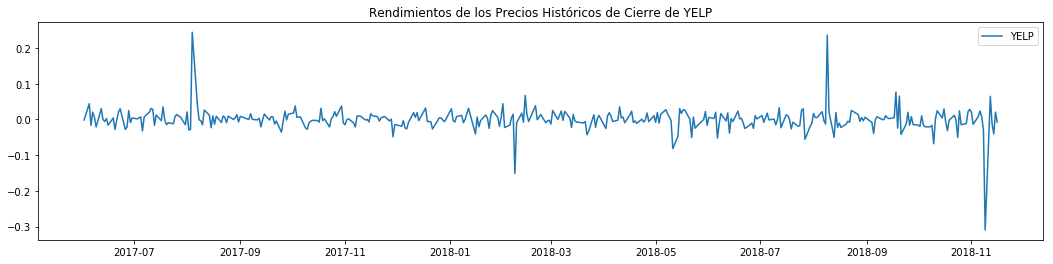

In [4]:
ret_ma = calc_daily_ret(closes_ma)
plt.figure(figsize = (18,4))
plt.plot(ret_ma)
plt.title('Rendimientos de los Precios Históricos de Cierre de YELP')
plt.legend(ticker1)
plt.show()

### CALL Europeo

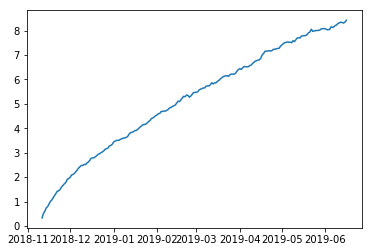

Prima de la Opción Calculada
Prima    8.421
Name: 2019-06-16 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(7.505911010005331, 9.33536132868333)
(7.506759251303376, 9.334513087385284)


In [5]:
mu = ret_ma.mean()[0]
sigma = ret_ma.std()[0]
r = 0.0273/360 # Tasa diaria, r = 0.0260/360, fecha del 11 de Noviembre de 2018
K= 33  # strike price
ndays = 218
nscen = 1000
dates = pd.date_range('2018-11-11', periods = ndays)
S0 = closes_ma.iloc[-1,0]  # Condición inicial del precio a simula
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()}, index=dates)
plt.plot(call)
plt.show()
print('Prima de la Opción Calculada')
C_RN = call.iloc[-1]
print(call.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### CALL Americano

In [6]:
def Call_Americano(sim_closes,K,r,ndays,nscen):
    a2 = np.array([sim_closes.iloc[j,-1]-K if sim_closes.iloc[j,1]-K > 0 else 0 for j in range(nscen)]) #indica cuales cumplen la condición del PayOff
    for t in range (ndays-1):
        a = a2*np.exp(-r)
        b = np.concatenate(np.array([a != 0])) #guarda en True-False las pocisiones de los que cumplen y no cumplen el PayOff
        c = a[a != 0] #guarda los valores que si cumplen la condición del PayOff
        d = np.array([sim_closes.iloc[j,-2-t] if b[j] == True else 0 for j in range(nscen)]) #toma los valores de un tiempo anterior de los indices guardados con los True-False
        e = d[d != 0] #guarda los valores de la linea anterior diferentes de 0
        f = min_cuad_americanas(e,c) #coeficientes de minimos cuadrados
        g = np.concatenate([f[0]+f[1]*d + f[2]*(d**2)]) #calcular los valores usando los coeficiente obtenidos
        g = np.array([g[j] if g[j] > 0 else 0 for j in range(len(g))])
        h = np.array([d[j]-K if d[j]-K >= g[j] else a[j] for j in range(nscen)]) # resultado comparando con los del tiempo no anterior
        h = np.array([h[j] if h[j] < K else 0 for j in range(len(h))])
        a2 = h
    return np.exp(-r)*h.mean()

In [7]:
Call_Americ = Call_Americano(sim_closes.T,K,r,ndays,nscen) 
Call_Americ

1.0035108029528474

### PUT Europeo

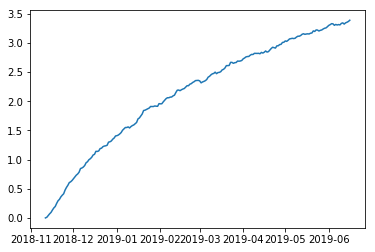

Prima de la Opción Calculada
Prima    3.386
Name: 2019-06-16 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(2.470423954250431, 4.3017367197155165)
(2.4712730590888876, 4.30088761487706)


In [8]:
mu = ret_ma.mean()[0]
sigma = ret_ma.std()[0]
r = 0.0273/360 # Tasa diaria, r = 0.0260/360, fecha del 11 de Noviembre de 2018
K= 30  # strike price
ndays = 218
nscen = 1000
dates = pd.date_range('2018-11-11', periods = ndays)
S0 = closes_ma.iloc[-1,0]  # Condición inicial del precio a simula
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros([ndays,nscen])).T.mean()}, index=dates)
plt.plot(put)
plt.show()
print('Prima de la Opción Calculada')
P_LP1_RN = put.iloc[-1]
print(put.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### PUT Americano

In [9]:
def Put_Americano(sim_closes,K,r,ndays,nscen):
    a2 = np.array([K-sim_closes.iloc[j,-1] if K-sim_closes.iloc[j,1] > 0 else 0 for j in range(nscen)]) #indica cuales cumplen la condición del PayOff
    for t in range (ndays-1):
        a = a2*np.exp(-r)
        b = np.concatenate(np.array([a != 0])) #guarda en True-False las pocisiones de los que cumplen y no cumplen el PayOff
        c = a[a != 0] #guarda los valores que si cumplen la condición del PayOff
        d = np.array([sim_closes.iloc[j,-2-t] if b[j] == True else 0 for j in range(nscen)]) #toma los valores de un tiempo anterior de los indices guardados con los True-False
        e = d[d != 0] #guarda los valores de la linea anterior diferentes de 0
        f = min_cuad_americanas(e,c) #coeficientes de minimos cuadrados
        g = np.concatenate([f[0]+f[1]*d + f[2]*(d**2)]) #calcular los valores usando los coeficiente obtenidos
        g = np.array([g[j] if g[j] > 0 else 0 for j in range(len(g))])
        h = np.array([K-d[j] if K-d[j] >= g[j] else a[j] for j in range(nscen)]) # resultado comparando con los del tiempo no anterior
        h = np.array([h[j] if h[j] < K else 0 for j in range(len(h))])
        a2 = h
    return np.exp(-r)*h.mean()

In [10]:
Put_Americ = Put_Americano(sim_closes.T,K,r*360,ndays,nscen) 
Put_Americ

0.04390449887550259

## Ejemplo

In [11]:
t1 = np.array([8.3826,11.9899,13.1381,6.8064,7.0508,11.2214,8.9672,11.5336])
t2 = np.array([9.9528,13.8988,17.4061,7.8115,9.1293,8.3600,8.7787,10.9398])
t3 = np.array([6.7581,14.5060,13.4123,10.6520,7.4551,9.2896,9.0822,8.6958])
tab = pd.DataFrame([t1,t2,t3]).T
ejemplo = Put_Americano(tab,12,.03/3,3,8) 
ejemplo

3.0918613970793